In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import sys
sys.path.append('drive/cyclegan_proj/')

In [0]:
from inception import InceptionSham
from data_sampler import SequentialSampler, BatchSampler, RandomSampler
from loss import compute_loss
from loss import consensus_loss
from inception import inception_score
import networks as net
from data_sampler import data_sampler
from utl import *

import numpy as np
import pandas as pd
from math import ceil

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output

In [0]:
train_pull = pd.read_csv("drive/cyclegan_proj/data/train_pull.csv", 
                         header=None).values
train_top = pd.read_csv("drive/cyclegan_proj/data/train_top.csv",
                        header=None).values
test_pull = pd.read_csv("drive/cyclegan_proj/data/test_pull.csv", 
                         header=None).values
test_top = pd.read_csv("drive/cyclegan_proj/data/test_top.csv",
                        header=None).values
train_n_obs = train_pull.shape[0]
test_n_obs = test_pull.shape[0]

In [0]:
inception_model = InceptionSham(num_classes=10, input_nc=1, dropout=0.5)
if torch.cuda.is_available():
    inception_model.cuda()
inception_state = torch.load("drive/cyclegan_proj/inception_sham_state.pth",)
inception_model.load_state_dict(inception_state)

In [0]:
# argparser or builder, where are you?
input_nc = 1
output_nc = 1
discr_filters = 8
max_power = 4
n_layers = 2
norm_lay = nn.BatchNorm2d
start_size = 28
gen_filters = 8
dropout = 0.5
n_blocks = 3
batch_size = 1
alpha = 10

use_gpu = False
if torch.cuda.is_available():
    use_gpu = True

In [0]:
discr_a = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size
)

discr_b = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size
)

gener_a = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

gener_b = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

if torch.cuda.is_available():
    discr_a.cuda()
    discr_b.cuda()
    gener_a.cuda()
    gener_b.cuda()

In [143]:
gener_a.apply(weights_init)
gener_b.apply(weights_init)
discr_a.apply(weights_init)
discr_b.apply(weights_init)
print("weights initialized")

weights initialized


In [0]:
from itertools import chain
adam_params = dict(lr=0.002, betas=(0.5, 0.999))

opt_discr = torch.optim.Adam(
    chain(discr_a.parameters(), discr_b.parameters()), 
    **adam_params)
opt_gener = torch.optim.Adam(
    chain(gener_a.parameters(), gener_b.parameters()),
    **adam_params)
opt_gener_a = torch.optim.Adam(gener_a.parameters(), **adam_params)
opt_gener_b = torch.optim.Adam(gener_b.parameters(), **adam_params)
opt_discr_a = torch.optim.Adam(discr_a.parameters(), **adam_params)
opt_discr_b = torch.optim.Adam(discr_b.parameters(), **adam_params)

In [0]:
discr_loss_log = []
gener_loss_log = []
da_loss_log = []
db_loss_log = []
ga_loss_log = []
gb_loss_log = []
ga_fool_log = []
gb_fool_log = []
gener_a_cyc_loss_log = []
gener_b_cyc_loss_log = []
consesus_a_log = []
consesus_b_log = []

da_grad_log, db_grad_log = [], []
ga_grad_log, gb_grad_log = [], []

incp_a_log, incp_b_log = [], []

In [0]:
# consensus weight
clambda = None
if clambda is not None:
    inp_grad = True
cons_norm = 1/2

Epoch 1


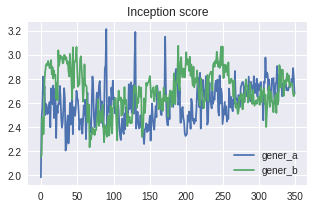

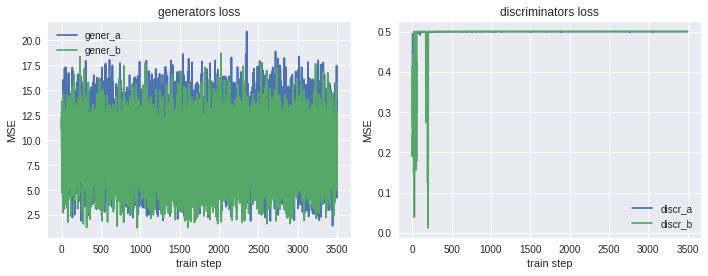

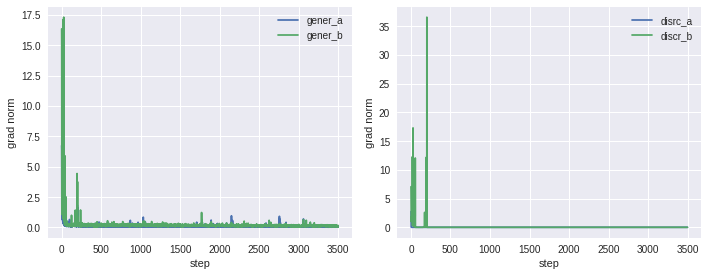

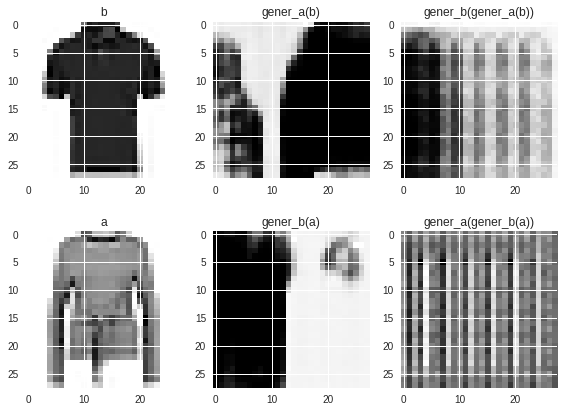

KeyboardInterrupt: ignored

In [147]:
N_EPOCHS = 5

print("Start")
for epoch in range(N_EPOCHS):

    sampler = RandomSampler(train_n_obs)
    batch_sampler_a = BatchSampler(sampler, batch_size)
    batch_sampler_b = BatchSampler(sampler, batch_size)

    for i, batches in enumerate(zip(batch_sampler_a, batch_sampler_b)):
        batch_a = Variable(
            aduc(
                torch.FloatTensor(train_pull[batches[0]]).view(-1, 1, 28, 28)),
            requires_grad=inp_grad)
        batch_b = Variable(
            aduc(torch.FloatTensor(train_top[batches[1]]).view(-1, 1, 28, 28)),
            requires_grad=inp_grad)

        train_stage(gener_a, gener_b, discr_a, discr_b)

        losses = compute_loss(
            gener_a, gener_b,
            discr_a, discr_b,
            batch_a, batch_b,
            alpha,
            discr_loss='mse',
            use_gpu=use_gpu)

        discr_loss, gener_loss = losses[0:2]
        da_loss, db_loss = losses[2:4]
        ga_loss, gb_loss = losses[4:6]
        ga_fool, gb_fool = losses[6:8]
        gener_a_cyc_loss, gener_b_cyc_loss = losses[8:10]
        
        if clambda is None:
            if i % 2 == 0:
                opt_discr.zero_grad()
                discr_loss.backward()

                torch.nn.utils.clip_grad_norm(gener_a.parameters(), 2)
                torch.nn.utils.clip_grad_norm(gener_b.parameters(), 2)

                opt_discr.step()

            else:
                opt_gener.zero_grad()
                gener_loss.backward()

                torch.nn.utils.clip_grad_norm(gener_a.parameters(), 2)
                torch.nn.utils.clip_grad_norm(gener_b.parameters(), 2)
                
                opt_gener.step()

        else:
            consesus_a = (consensus_loss(da_loss, discr_a) + 
                          consensus_loss(ga_loss, gener_a)) * cons_norm * 1/2
            consesus_b = (consensus_loss(db_loss, discr_b) + 
              consensus_loss(gb_loss, gener_b)) * cons_norm * 1/2
            
            consesus_a_log.append(consesus_a.data[0])
            consesus_b_log.append(consesus_b.data[0])
            
            discr_a_mega_loss = da_loss - clambda * consesus_a
            discr_b_mega_loss = db_loss - clambda * consesus_b
            gener_a_mega_loss = ga_loss - clambda * consesus_a
            gener_b_mega_loss = gb_loss - clambda * consesus_b

            lossic = (gener_b_mega_loss + discr_b_mega_loss + 
                     gener_a_mega_loss + gener_b_mega_loss)
            
            opt_gener_a.zero_grad()
            opt_gener_b.zero_grad()
            opt_discr_a.zero_grad()
            opt_discr_b.zero_grad()

            lossic.backward()
            
            torch.nn.utils.clip_grad_norm(gener_a.parameters(), 5)
            torch.nn.utils.clip_grad_norm(gener_b.parameters(), 5)
            
            torch.nn.utils.clip_grad_norm(gener_a.parameters(), 5)
            torch.nn.utils.clip_grad_norm(gener_b.parameters(), 5)
#             (discr_a_mega_loss).backward(retain_graph=True)
#             (discr_b_mega_loss).backward(retain_graph=True)
#             (gener_a_mega_loss).backward(retain_graph=True)
#             (gener_b_mega_loss).backward()

            opt_gener_a.step()
            opt_gener_b.step()
            opt_discr_a.step()
            opt_discr_b.step()
            
            
         
        ga_grad_log.append(grad_norm(gener_a))
        gb_grad_log.append(grad_norm(gener_b))
        da_grad_log.append(grad_norm(discr_a))
        db_grad_log.append(grad_norm(discr_b))

        discr_loss_log.append(discr_loss.data[0])
        gener_loss_log.append(gener_loss.data[0])
        da_loss_log.append(da_loss.data[0])
        db_loss_log.append(db_loss.data[0])
        ga_loss_log.append(ga_loss.data[0])
        gb_loss_log.append(gb_loss.data[0])
        ga_fool_log.append(ga_fool.data[0])
        gb_fool_log.append(gb_fool.data[0])
        gener_a_cyc_loss_log.append(gener_a_cyc_loss.data[0])
        gener_b_cyc_loss_log.append(gener_b_cyc_loss.data[0])


        if i % 10 == 0:
            incp_a, incp_b = inception_score(
                gener_a, gener_b,
                inception_model,
                test_pull, test_top,
                batch_size=100,
                splits=10)

            incp_a_log.append(incp_a)
            incp_b_log.append(incp_b)

    # visualize every epoch
        if (i + 1) % 100 == 0:
            clear_output()
            print("Epoch {}".format(epoch + 1))

            plt.figure(figsize=(5, 3))
            plt.plot(incp_a_log, label="gener_a")
            plt.plot(incp_b_log, label="gener_b")
            plt.title('Inception score')
            plt.legend()
            plt.show()

            sample_a, sample_b = data_sampler(
                1, train_pull, train_top, use_gpu=use_gpu)        
            visualize_loss(da_loss_log, db_loss_log,
                           ga_loss_log, gb_loss_log,
                           exp_window=None)
            plot_grad_norms(da_grad_log, db_grad_log,
                            ga_grad_log, gb_grad_log)
            plot_geners(sample_a, sample_b,

                        gener_a, gener_b)

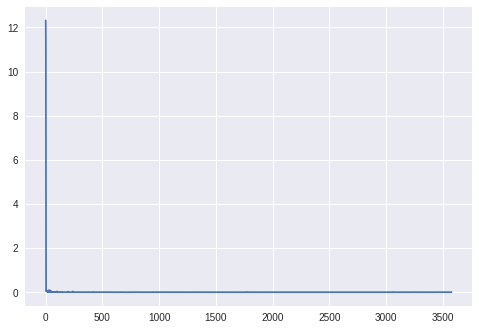

In [149]:
plt.plot(consesus_a_log)

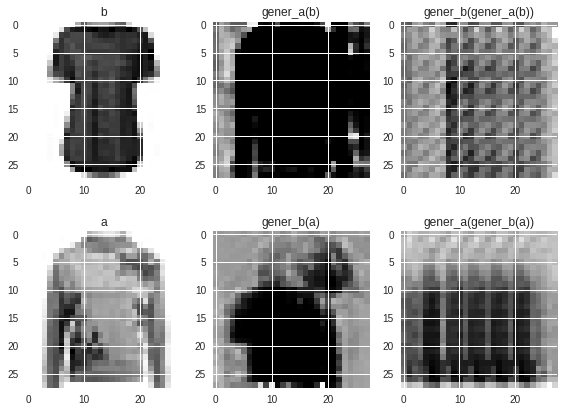

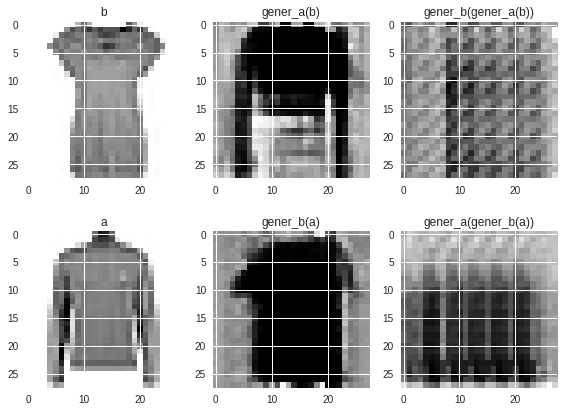

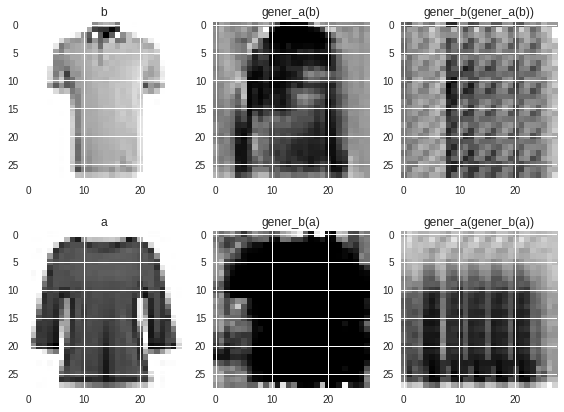

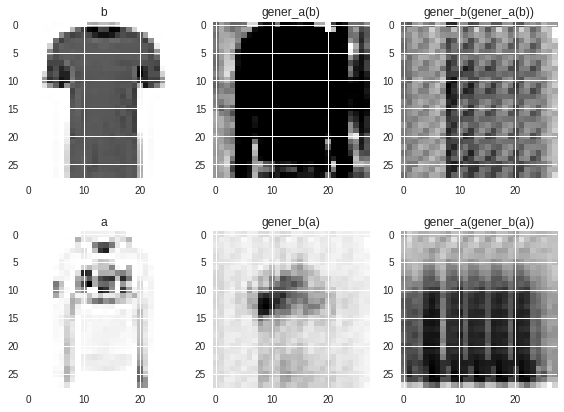

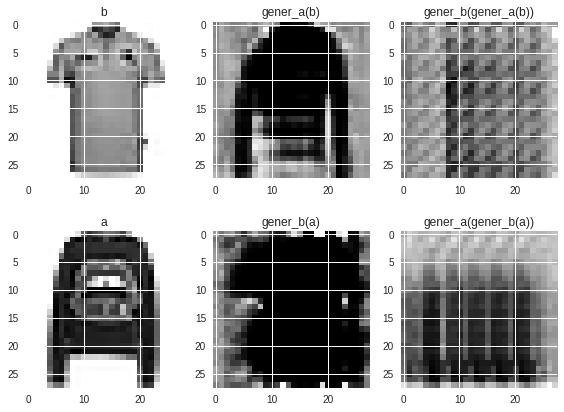

In [64]:
for i in range(5):
  sample_a, sample_b = data_sampler(1, train_pull, train_top, use_gpu=True)
  plot_geners(sample_a, sample_b, gener_a, gener_b)

In [42]:
gb_grad_log

[inf,
 2837.567489955958,
 3379.006372697793,
 3458.5167927629436,
 11047.030460170932,
 2285.7329640296057,
 2771.300513900276,
 3302.0113981553895,
 3051.616629801879,
 4433.3685210047015,
 3104.4070111144083,
 5472.881040173502,
 17451.684569909125,
 5222.451112241832,
 4974.57402166645,
 4399.960090594746,
 3683.171705144062,
 3376.2278498382,
 3529.2521962985998,
 9282.018063896237,
 2969.2282234863173,
 9735.194950637855,
 6792.083510743105,
 7010.478622952845,
 3994.468714980717,
 9772.933956369941,
 5946.57879459656,
 3697.0598373732337,
 4524.584420437862,
 9186.472063585716,
 3573.048285719821,
 4494.231577078627,
 4388.621407311095,
 4421.986792822092,
 4893.116501030837,
 4479.572755572241,
 4585.326772831058,
 7170.396776469167,
 13355.17177679401,
 3592.6414372134527,
 4610.8946790181635,
 3979.871399324226,
 4264.787540547234,
 6080.411052666739,
 8407.8279366432,
 3253.66006295311,
 11814.126154084306,
 25867.026113162956,
 5320.077402493067,
 3267.2303652500764,
 7799.